In [35]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit_aer import AerSimulator
from math import sqrt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [10]:
#at the simplest level, implementing the surface code requires at least 5 qubits (four for data, one for measurement)
qubit_register = QuantumRegister(5)

#we will also want to have a classsical bit to store measurement outcome

classical_register = ClassicalRegister(1)

#from this we can initialize our circuit

qc = QuantumCircuit(qubit_register, classical_register)


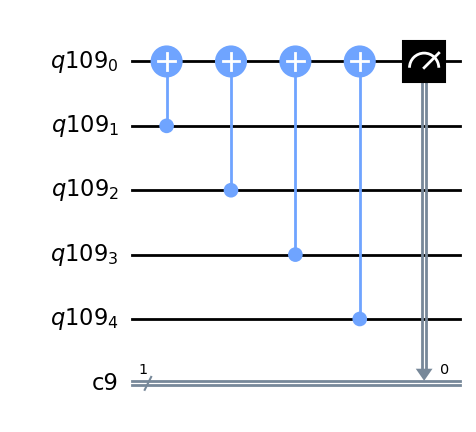

In [11]:
# We can make this example Z symdrome or X syndrome. This means that a measurement cycle either takes the system to an eigenstate of ZaZbZcZd or XaXbXcXd

#for measure-Z case, the cycle consists of applying cnot to each qubit+ancilla, to entangle every data qubit with the measurement qubit

def zcycle(qc):
    for i in range(1,5):
        qc.cx(qubit_register[i], qubit_register[0])
    return qc

qc = zcycle(qc)

#measuring the ancilliary qubit

qc.measure(0,0)

qc.draw()


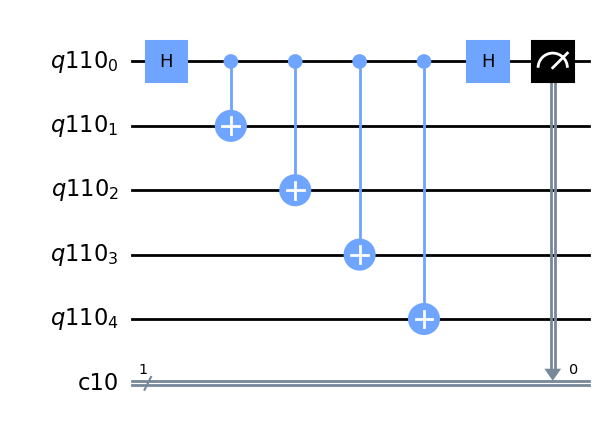

In [12]:
#for measure-X case, the cycle is implemented by the following circuit

qubit_register = QuantumRegister(5)
classical_register = ClassicalRegister(1)
qc = QuantumCircuit(qubit_register, classical_register)

def xcycle(qc):
    qc.h(qubit_register[0])
    for i in range(1,5):
        qc.cx(qubit_register[0], qubit_register[i])

    qc.h(qubit_register[0])
    return qc

qc = xcycle(qc)

#measuring the ancilliary qubit

qc.measure(0,0)

qc.draw()


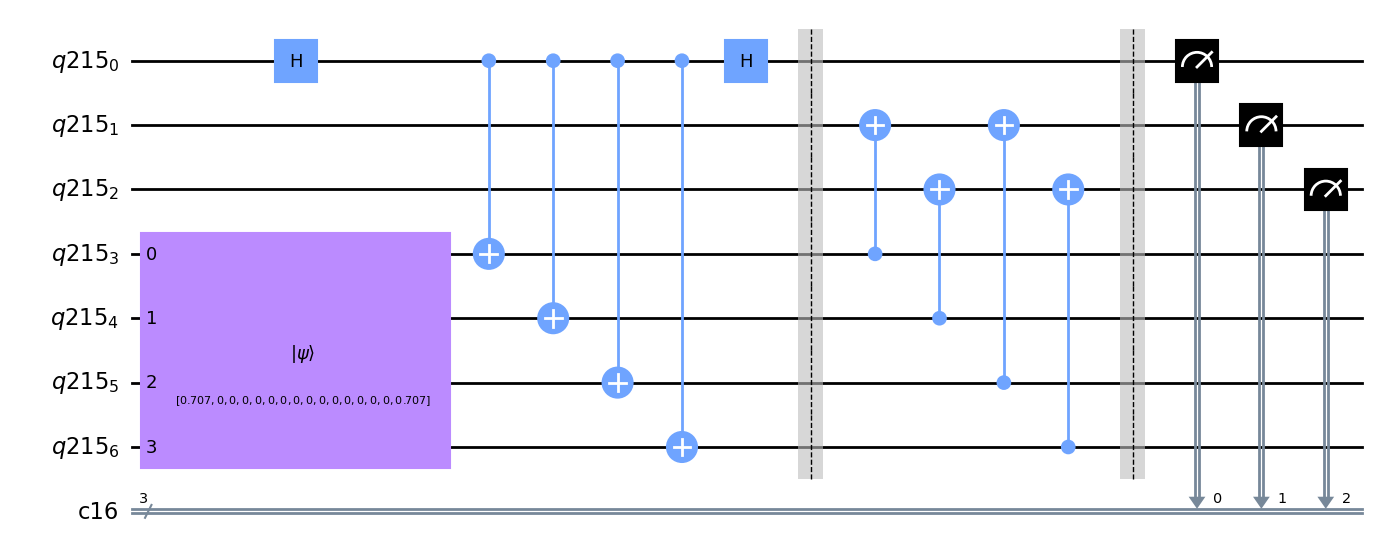

In [72]:
#after running a cycle we should in theory measure the same result in subsequent cycles, however we could run into several errors
#(in gates, measurement, qubit initialization, etc). However surface codes are generally known to be resitant to errors

#Implementing a circuit to detect quantum errors in surface code:

#We can detect d-1 errors per cycle. This means we need at least d=2 in our sirface code circuit to visualize the code detection. 
#d represents the code distance (array of qubits has six dxd, and d^2-1 ancilla qubits)
#in the minimal case: d=2, 4 data qubits, 3 ancilla/measurement qubits

qubit_register = QuantumRegister(7)
classical_register = ClassicalRegister(3)
qc = QuantumCircuit(qubit_register, classical_register)

#equal likelihood of 0000 and 1111 as initial state
init_state = [sqrt(0.5), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, sqrt(0.5)]
qc.initialize(init_state, [3, 4, 5, 6])

#we will need three different stabilizers

def x4_stabilizer(qc):
    #x ancilla is qubit 0
    qc.h(qubit_register[0])
    for i in range(3,7):
        qc.cx(qubit_register[0], qubit_register[i])
    qc.h(qubit_register[0])
    return qc

def z13_stabilizer(qc):
    #first z ancilla is qubit 1
    qc.cx(qubit_register[3],qubit_register[1])
    qc.cx(qubit_register[5],qubit_register[1])
    return qc

def z24_stabilizer(qc):
    #second z ancilla is qubit 2
    qc.cx(qubit_register[4],qubit_register[2])
    qc.cx(qubit_register[6],qubit_register[2])
    return qc

#the stabilizers are applied in the order they have been defined

def stabilizer_cycles(qc, n_cycles):
    for i in range(n_cycles):
        qc = x4_stabilizer(qc)
        qc.barrier()
        qc = z13_stabilizer(qc)
        qc = z24_stabilizer(qc)
        qc.barrier()
    return qc

qc = stabilizer_cycles(qc,1)

#and again we measure the ancilla
for i in range(0,3):
    qc.measure(qubit_register[i],classical_register[i])

qc.draw()

# a limitation of this small circuit is that we can't really distinguish which data qubit suffered an error

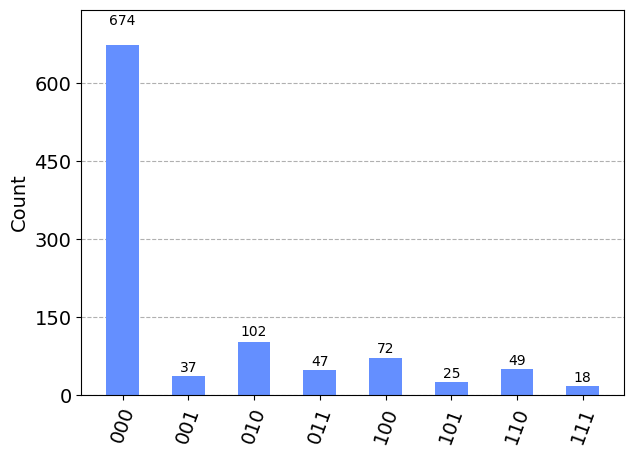

In [76]:
#To run the stabilizer cycles I will start from the ideal smilation backend and implement a simple bit flip error noise model as shown in the
#qiskit documentation

p_reset = 0.03
p_meas = 0.01
p_gate1 = 0.01

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(qc, sim_noise)

circ_tnoise.draw()

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts()

# Plot noisy output
plot_histogram(counts_bit_flip)


#count=result_bit_flip.get_counts()
#print(count['000'])


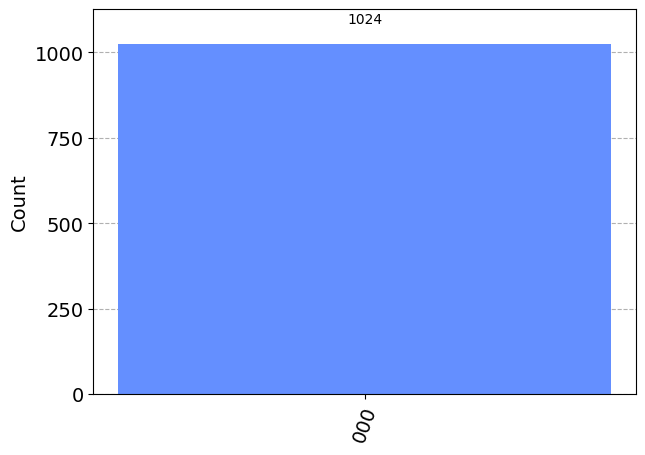

In [74]:
#without errors
aer_sim = AerSimulator()

# Run and get counts
result_no_err = aer_sim.run(qc).result()
counts_no_err = result_no_err.get_counts()

# Plot output
plot_histogram(counts_no_err)

{'000': 1024}
